In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, cross_validate
from sklearn.metrics import make_scorer, f1_score, recall_score, precision_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('rslp')

[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\vinic\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping stemmers\rslp.zip.


True

In [2]:
df_original = pd.read_csv('./b2w.csv')
df_original.head()

,original_index,review_text,review_text_processed,review_text_tokenized,polarity,rating,kfold_polarity,kfold_rating
0,11955,Bem macio e felpudo...recomendo. Preço imbatí...,bem macio e felpudo...recomendo. preco imbati...,"['bem', 'macio', 'felpudo', 'recomendo', 'prec...",1.0,4,1,1
1,35478,Produto excepcional! recomendo!!! inovador e ...,produto excepcional! recomendo!!! inovador e ...,"['produto', 'excepcional', 'recomendo', 'inova...",1.0,5,1,1
2,122760,recebi o produto antes do prazo mas veio com d...,recebi o produto antes do prazo mas veio com d...,"['recebi', 'produto', 'antes', 'do', 'prazo', ...",0.0,1,1,1
3,17114,Bom custo beneficio. Adequado para pessoas que...,bom custo beneficio. adequado para pessoas que...,"['bom', 'custo', 'beneficio', 'adequado', 'par...",1.0,5,1,1
4,19112,Além de higiênico tem o tamanho ideal. Só falt...,alem de higienico tem o tamanho ideal. so falt...,"['alem', 'de', 'higienico', 'tem', 'tamanho', ...",NaN,3,-1,1


In [3]:
def label_polarity(rating):
    if rating < 3:
        return 'negative'
    elif rating > 3:
        return 'positive'
    else:
        return 'neutral'

df = pd.DataFrame({'text': df_original["review_text"], 'polarity': df_original['rating'].apply(label_polarity)})
df.head()

,text,polarity
0,Bem macio e felpudo...recomendo. Preço imbatí...,positive
1,Produto excepcional! recomendo!!! inovador e ...,positive
2,recebi o produto antes do prazo mas veio com d...,negative
3,Bom custo beneficio. Adequado para pessoas que...,positive
4,Além de higiênico tem o tamanho ideal. Só falt...,neutral


In [4]:
df.polarity.value_counts()

positive    80300
negative    35758
neutral     16315
Name: polarity, dtype: int64

In [5]:
positive = df.query("polarity == 'positive'").sample(16000)
negative = df.query("polarity == 'negative'").sample(16000)
neutral = df.query("polarity == 'neutral'").sample(16000)
df = pd.concat([positive, negative, neutral])
df.polarity.value_counts()

positive    16000
negative    16000
neutral     16000
Name: polarity, dtype: int64

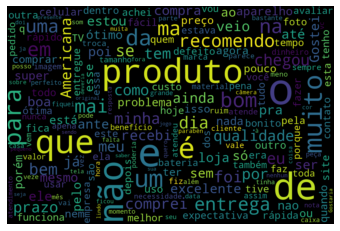

In [6]:
def show_wordcloud(dataframe: pd.DataFrame, column: str):
    all_words = ' '.join([ text for text in dataframe[column] ])
    word_cloud = WordCloud(width=1200, height=800, max_font_size=160, collocations=False).generate(all_words)
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
show_wordcloud(df, "text")

In [7]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub("\d+", '', text)
    text = text.replace("\n", "")
    text = re.sub("https?://[A-Za-z0-9]*", ' ', text)
    return text

df["processed_text"] = df['text'].apply(preprocess_text)
df.head()

,text,polarity,processed_text
57672,"Recebi no prazo , produto de boa qualidade e b...",positive,"recebi no prazo , produto de boa qualidade e b..."
9630,"Estou indo agora no banco, vou penhorar o carr...",positive,"estou indo agora no banco, vou penhorar o carr..."
44266,"Material de qualidade, perfeito! Chegou bem a...",positive,"material de qualidade, perfeito! chegou bem a..."
39038,"Produto entregue no prazo, sem defeitos, de ac...",positive,"produto entregue no prazo, sem defeitos, de ac..."
119696,Excelente produto...atendeu perfeitamente as m...,positive,excelente produto...atendeu perfeitamente as m...


In [27]:
def stemmizer(dataframe: pd.DataFrame, text_column: str):
    whitespace_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    stemmer = nltk.RSLPStemmer()
    treated_data = []
    for review in dataframe[text_column]:
        tokenized_review = whitespace_tokenizer.tokenize(review)
        treated_review = []
        for word in tokenized_review:
            treated_review.append(stemmer.stem(word))
        treated_data.append(' '.join(treated_review))
    dataframe["treat_stem"] = treated_data
    
stemmizer(df, "processed_text")
df.head()

,text,polarity,processed_text,treat_stem
57672,"Recebi no prazo , produto de boa qualidade e b...",positive,"recebi no prazo , produto de boa qualidade e b...","receb no praz , produt de boa qual e bem útil...."
9630,"Estou indo agora no banco, vou penhorar o carr...",positive,"estou indo agora no banco, vou penhorar o carr...","est ind agor no banco, vou penhor o carr e a c..."
44266,"Material de qualidade, perfeito! Chegou bem a...",positive,"material de qualidade, perfeito! chegou bem a...","mater de qualidade, perfeito! cheg bem ant da ..."
39038,"Produto entregue no prazo, sem defeitos, de ac...",positive,"produto entregue no prazo, sem defeitos, de ac...","produt entreg no prazo, sem defeitos, de acord..."
119696,Excelente produto...atendeu perfeitamente as m...,positive,excelente produto...atendeu perfeitamente as m...,excel produto...atend perfeit as minh expectat...


In [19]:
stop_words = set(stopwords.words("portuguese"))
count_vectorizer = CountVectorizer(lowercase = False, max_features = 100)
bag_of_words = count_vectorizer.fit_transform(df["processed_text"])

In [20]:
x_train, x_test, y_train, y_test = \
    train_test_split(
        bag_of_words, 
        df["polarity"],
        stratify = df["polarity"],
        shuffle = True,
        random_state = 42
    )

In [21]:
first_analysis = LogisticRegression()
first_analysis.fit(x_train, y_train)
accuracy = first_analysis.score(x_test, y_test)
accuracy

0.66925